### Mariam Adeyemo
BDP Final Project

## Part 5

**Tweets uniqueness**

In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [4]:
#pip install nltk -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 55.9 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.4
    Uninstalling nltk-3.6.4:
      Successfully uninstalled nltk-3.6.4
Note: you may need to restart the kernel to use updated packages.


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## Question 4: How unique are the messages?

### Loading the processed tweet into spark dataframe

In [5]:
path_read = 'gs://msca-bdp-students-bucket/shared_data/mariamoluwatobi/categorised_twitterers'

In [6]:
%%time

tweets_filt4 = spark.read.parquet(path_read)

CPU times: user 3.67 ms, sys: 4.73 ms, total: 8.4 ms
Wall time: 7.28 s


23/03/10 20:59:36 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
tweets_filt4.count()

36600074

### Sample my tweet data

I tried all my possible best to work on the whole dataset, however, I kept getting an insufficient memory error message from Pandas whenever I get to the part of establishing the Jaccard similaries. So, I will be using a subset of my sample to run the Jaccard similarities

In [7]:
#first filter for original tweets using the "retweeted_status"
original_tweet = tweets_filt4.filter(col("tweet_retweeted_status").isNull())

original_tweet.limit(5)

user_id,user_name,user_screen_name,user_created_at,user_location,user_description,user_verified,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,tweet_id_str,tweet_created_at,tweet_text,text,tweet_quote_count,tweet_is_quote_status,tweet_timestamp_ms,tweet_retweeted_from,tweet_reply_count,tweet_retweeted_status,tweet_possibly_sensitive,tweet_favorite_count,tweet_location,tweet_city,tweet_coordinates,user_category
1446325690551341056,Naija Tabloid,naija_tabloid,2021-10-08 04:05:22,"Abuja, Nigeria",The Best Online P...,false,66,15,0,49102,1599504337394352129,2022-12-04 20:42:06,Atiku should lowe...,atiku should lowe...,0,false,1670186526045,null,0,null,false,0,null,null,null,News Outlet
1583111392894197760,Ryleigh.Mueller49...,mueller49cbrv,2022-10-20 15:02:32,null,null,false,5,2,0,3655,1599504346861162496,2022-12-04 20:42:08,Bluey Girls &amp;...,bluey girls amp b...,0,false,1670186528302,null,0,null,false,0,null,null,null,Someone Else
1035242686855487489,Jalik Thomas,ThomasJalik,2018-08-30 19:07:45,"Macon, GA",6’0 200 DB @ Hutc...,false,1017,428,1509,686,1599504355706605568,2022-12-04 20:42:10,After an great co...,after an great co...,0,false,1670186530411,ECU_Coach_Weave I...,0,null,false,0,null,null,null,University
1293807167028563969,Metalady🇺🇦🐈‍⬛,Alice_inpains,2020-08-13 07:10:55,null,\m/,false,284,215,5557,7667,1599504362547867649,2022-12-04 20:42:12,Why is Biden twee...,why is biden twee...,0,false,1670186532042,null,0,null,null,0,null,null,null,Someone Else
1520936616298168320,𝕮𝖔𝖗𝖛𝖎𝖉𝖆𝖊 🐀,urcorvidae,2022-05-02 01:22:09,"she/her, Illinois",aspiring big tidd...,false,104,324,10387,2533,1599504369065480192,2022-12-04 20:42:13,@meangirlboy you ...,meangirlboy you m...,0,false,1670186533596,null,0,null,null,0,null,null,null,Someone Else


In [9]:
original_tweet.count()

13022551

In [10]:
original_tweet_sample = original_tweet.sample(False, 0.004, 12345)
original_tweet_sample.count()

52481

#### Select the columns needed from the data

In [11]:
original_tweet_sample1 = original_tweet_sample.select('user_id','user_category',col('tweet_text').alias('text'))

In [12]:
#select the text column from the data for further analysis
original_tweet_sample2 = original_tweet_sample1.select(["text"])
original_tweet_sample2.limit(5)

text
As .@Makerere con...
Jasmine Young App...
"In spring 2021, S..."
@lewysj @JoePlane...
@NoLieWithBTC My ...


## Assessing the similarity on the text

### Step 1. Clean the title data, remove stopwords and create index for the combined text

I will first remove all null values in the table, then I will convert all characters to lower case, split the each document by white space to get a list of all tokens, then remove all stopwords, and remove all words that have a length less than or equal to 1.

In [ ]:
# drop any rows with null values
text = original_tweet_sample2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens1 = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [14]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{Every scene coul...,269
{Together we are ...,270
{@jokelley @Lalee...,271
{@SiestaSocialist...,272
{Someone tell the...,273


In [ ]:
df_text.count()

23/03/09 01:12:30 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 3 for reason Container marked as failed: container_1678319559471_0004_01_000003 on host: hub-msca-bdp-dphub-students-mariamoluwatobi-sw-38r3.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/03/09 01:12:30 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 3 on hub-msca-bdp-dphub-students-mariamoluwatobi-sw-38r3.c.msca-bdp-students.internal: Container marked as failed: container_1678319559471_0004_01_000003 on host: hub-msca-bdp-dphub-students-mariamoluwatobi-sw-38r3.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/03/09 01:13:39 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 29.0 (TID 2923) (hub-msca-bdp-dphub-students-mariamoluwatobi-w-0.c.msca-bdp-students.internal executor 24): FetchFailed(BlockManag

52481

In [16]:
df_text_tokens = spark.createDataFrame(tokens1, ["words_list",'id'])

#Drop records with no tokens
df_text_tokens = df_text_tokens.where(col('words_list').getItem(0).isNotNull())
df_text_tokens.limit(5).toPandas()

,words_list,id
0,"[continues, celebrate, 100, years, university, system, makerere, advance, system, initiative, designed, build, digital, interactive, alumni]",0
1,"[jasmine, young, appointed, director, school, business, howard, warner, music, university, blavatnik, center, entertainment]",1
2,"[spring, school, engineering, students, participated, project, develop, educational, resources, bridge, historic, bridge, located, shelburne]",2
3,"[phd, education, pay, school, think, financial, model, sure, julie, deserves, bills, covered, also, earning, advanced, education, student, loans, take, cover]",3
4,"[graduates, high, school, tonight, talking, last, class, discuss, really, feel, schools, show, discussion, real, time, economics, like, gas, food]",4


### Step 2. Fit countvectorizer to create word features for the text.

I will create a matrix of the frequency of each word in each document using the Count Vectorizer.

In [17]:
vectorize1 = CountVectorizer(inputCol="words_list", outputCol="features", minDF=1.0)
df_text_vectorize = vectorize1.fit(df_text_tokens).transform(df_text_tokens)

In [18]:
df_text_vectorize.limit(5).toPandas()

,words_list,id,features
0,"[continues, celebrate, 100, years, university, system, makerere, advance, system, initiative, designed, build, digital, interactive, alumni]",0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[jasmine, young, appointed, director, school, business, howard, warner, music, university, blavatnik, center, entertainment]",1,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[spring, school, engineering, students, participated, project, develop, educational, resources, bridge, historic, bridge, located, shelburne]",2,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[phd, education, pay, school, think, financial, model, sure, julie, deserves, bills, covered, also, earning, advanced, education, student, loans, take, cover]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[graduates, high, school, tonight, talking, last, class, discuss, really, feel, schools, show, discussion, real, time, economics, like, gas, food]",4,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Step 3. Fit MinHashLSH to create hash table for the text

I will then hash the count vectorizer into a compressed signature. I added 5 hash tables to increase the accuracy, even though this will take more time.

In [19]:
mh1 = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model1 = mh1.fit(df_text_vectorize)
df_hashed1 = model1.transform(df_text_vectorize).cache()

In [ ]:
df_hashed_text = df_text.join(df_hashed1, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,words_list,features,hashes
26,{Delaware State U...,"[delaware, state,...","(42091,[3,34,593,...","[[2.2304672E8], [..."
29,{Seriously?! What...,"[joke, coming, le...","(42091,[12,22,77,...","[[2.41716268E8], ..."
474,{@LisaOverachieve...,"[graduated, high,...","(42091,[0,2,150],...","[[4.7945584E7], [..."
964,{What a better wa...,"[better, way, sta...","(42091,[2,30,33,7...","[[2.17491001E8], ..."
1677,{Perfect second f...,"[perfect, second,...","(42091,[3,87,369,...","[[1.44838789E8], ..."


In [21]:
df_hashed_text.printSchema()

root
 |-- id: long (nullable = true)
 |-- text: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |-- words_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- hashes: array (nullable = true)
 |    |-- element: vector (containsNull = true)



### Step 4. Establish similarity threshold and return near-duplicate records
**Note:** we are joining dataframe to itself to get near-duplicate pairs
        
**I am also going to be using Jaccard threshold of 0.3, 0.5, and 0.7 to test for the similarities between the text and identify the right Jaccard similarity for the corpus.**

#### Jaccard 0.3

I am going to join the dataframe to itself to get a near-duplicate pair if the jaccard distance between the combination of the hash values is 0.3 or less

In [21]:
jaccard_distance = 0.3

df_dups_text3 = model1.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
df_dups_30 = df_dups_text3
df_dups_text3.cache()
df_dups_text3.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,3869,30989,"(Use of any relationship consumer order thing scene check college car include city. https://t.co/GBF60Eqq39,)","(Use of any relationship consumer order thing scene check college car include city. https://t.co/54AXbMf56b,)"
1,0.0,3869,38256,"(Use of any relationship consumer order thing scene check college car include city. https://t.co/GBF60Eqq39,)","(Use of any relationship consumer order thing scene check college car include city. https://t.co/eMq61jbw1q,)"
2,0.0,27814,34529,"(@SaharaReporters This is a university ffs!!!,)","(@geneVIBE_ University is a scam, man.,)"
3,0.0,34639,43036,"(Happy total section for college win capital serve collection part song agreement. https://t.co/bK1WCbVll9,)","(@michele_gillam1 Happy total section for college win capital serve collection part song agreement.,)"
4,0.0,34639,50570,"(Happy total section for college win capital serve collection part song agreement. https://t.co/bK1WCbVll9,)","(Happy total section for college win capital serve collection part song agreement. https://t.co/v3HvJYSR2c,)"


In [23]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  52481
Duplicate titles based on { 0.3 } jaccard distance:  3980
Unique titles based on { 0.3 } jaccard distance:  0.3 :  48501


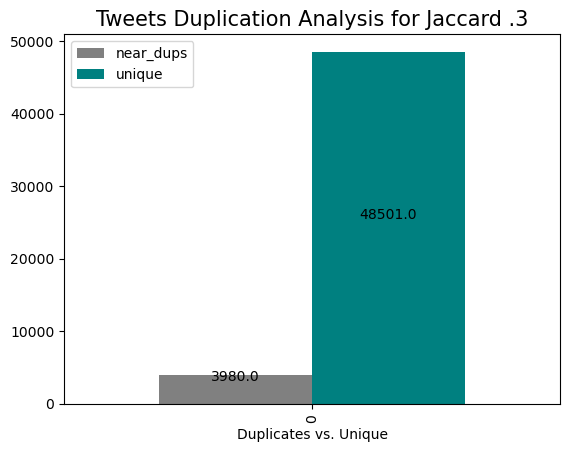

In [24]:
dups3_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups3_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['grey', 'teal'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets Duplication Analysis for Jaccard .3', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2),  
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

The bar chart above shows the **count of the unique and near-duplicate tweets from the Jaccard threshold of 0.3. It shows that out of about 52,000 plus records analyzed, 3,980 tweets are identified to be near-duplicate and 48,501 tweets are unique.**

#### Jaccard 0.5

I am going to join the dataframe to itself to get a near-duplicate pair if the jaccard distance between the combination of the hash values is 0.5 or less

In [25]:
jaccard_distance = 0.5

df_dups_text5 = model1.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [26]:
df_dups_50 = df_dups_text5
df_dups_text5.cache()
df_dups_text5.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,3869,30989,"(Use of any relationship consumer order thing scene check college car include city. https://t.co/GBF60Eqq39,)","(Use of any relationship consumer order thing scene check college car include city. https://t.co/54AXbMf56b,)"
1,0.0,3869,38256,"(Use of any relationship consumer order thing scene check college car include city. https://t.co/GBF60Eqq39,)","(Use of any relationship consumer order thing scene check college car include city. https://t.co/eMq61jbw1q,)"
2,0.0,27814,34529,"(@SaharaReporters This is a university ffs!!!,)","(@geneVIBE_ University is a scam, man.,)"
3,0.0,34639,43036,"(Happy total section for college win capital serve collection part song agreement. https://t.co/bK1WCbVll9,)","(@michele_gillam1 Happy total section for college win capital serve collection part song agreement.,)"
4,0.0,34639,50570,"(Happy total section for college win capital serve collection part song agreement. https://t.co/bK1WCbVll9,)","(Happy total section for college win capital serve collection part song agreement. https://t.co/v3HvJYSR2c,)"


In [27]:
records5 = df_hashed_text.count()
dups5 = df_dups_text5.select('id_A').distinct().count()
uniques5 = records5 - dups5

print ('Total records: ', records5)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups5)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques5)

Total records:  52481
Duplicate titles based on { 0.5 } jaccard distance:  7104
Unique titles based on { 0.5 } jaccard distance:  0.5 :  45377


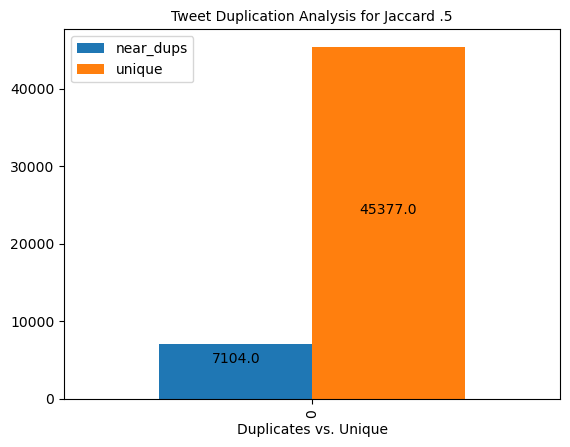

In [28]:
dups5_df = pd.DataFrame.from_dict({'near_dups': [dups5], 'unique': [uniques5]})

ax=dups5_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweet Duplication Analysis for Jaccard .5', fontsize=10)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

The bar chart above shows the **count of the unique and near-duplicate tweets from the Jaccard threshold of 0.5. It shows that out of about 52,000 plus records analyzed, 7,104 tweets are identified to be near-duplicate and 45,377 tweets are unique.**

There is an increase in the number of near-duplicate tweets identified by Jaccard 0.5 and a decrease in the number of unique tweets compared to Jaccard threshold of 0.3

#### Jaccard 0.7

I am going to join the dataframe to itself to get a near-duplicate pair if the jaccard distance between the combination of the hash values is 0.7 or less

In [29]:
jaccard_distance = 0.7

df_dups_text7 = model1.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [30]:
df_dups_70 = df_dups_text7
df_dups_text7.cache()
df_dups_text7.limit(3).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,3869,30989,"(Use of any relationship consumer order thing scene check college car include city. https://t.co/GBF60Eqq39,)","(Use of any relationship consumer order thing scene check college car include city. https://t.co/54AXbMf56b,)"
1,0.000000,3869,38256,"(Use of any relationship consumer order thing scene check college car include city. https://t.co/GBF60Eqq39,)","(Use of any relationship consumer order thing scene check college car include city. https://t.co/eMq61jbw1q,)"
2,0.666667,4473,5554,"(@MarthaTilghman @saularm653 Where did you go to high school?,)","(the reason why people go to that high school everyday https://t.co/jXRGMg68G3,)"


In [31]:
records7 = df_hashed_text.count()
dups7 = df_dups_text7.select('id_A').distinct().count()
uniques7 = records7 - dups7

print ('Total records: ', records7)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups7)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques7)

Total records:  52481
Duplicate titles based on { 0.7 } jaccard distance:  18188
Unique titles based on { 0.7 } jaccard distance:  0.7 :  34293


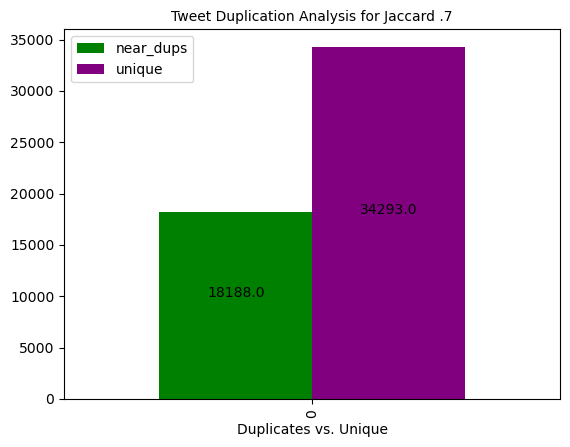

In [32]:
dups7_df = pd.DataFrame.from_dict({'near_dups': [dups7], 'unique': [uniques7]})

ax=dups7_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['green', 'purple'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweet Duplication Analysis for Jaccard .7', fontsize=10)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

The bar chart above shows the **count of the unique and near-duplicate tweets from the Jaccard threshold of 0.7. It shows that out of about 52,000 plus records analyzed, 18,188 tweets are identified to be near-duplicate and 34,293 tweets are unique.**

There is an increase in the number of near-duplicate tweets identified by Jaccard 0.7 and a decrease in the number of unique tweets compared to Jaccard threshold of 0.3 and 0.5

### Step 5. Compare thresholds side-by-side

In [33]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

289086


355562


1685983


In [34]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5)

text_A,text_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
{Use of any relat...,{Use of any relat...,3869,30989,3869,30989,3869,30989
{Use of any relat...,{Use of any relat...,3869,38256,3869,38256,3869,38256
{@MarthaTilghman ...,{the reason why p...,4473,5554,null,null,null,null
{@MarthaTilghman ...,{@CoachPagan Marc...,4473,10204,null,null,null,null
{@JoJoFromJerz Al...,{middle school tr...,6555,44091,null,null,null,null


#### Create a Duplicate vs Non-Dup flag for each jaccard similarity

In [35]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined.limit(5)

text_A,text_B,threshold_30,threshold_50,threshold_70
{@LisaOverachieve...,{@AngryBlackLady ...,Non-Dup,Non-Dup,Duplicate
{@LisaOverachieve...,{@newplayascircle...,Non-Dup,Non-Dup,Duplicate
{@LisaOverachieve...,{In senior high s...,Non-Dup,Non-Dup,Duplicate
{@LisaOverachieve...,{In high school -...,Non-Dup,Non-Dup,Duplicate
{@LisaOverachieve...,{A high school He...,Non-Dup,Non-Dup,Duplicate


#### Select a sample of records across 3 thresholds (jaccard similarities):

In [36]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(7).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(7)).\
union\
(dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(7)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [37]:
pd.set_option('display.max_rows', 21)
dups_combined_sample.toPandas()

,text_A,text_B,threshold_30,threshold_50,threshold_70
0,"(Happy total section for college win capital serve collection part song agreement. ['https://t.co/3J8jjgja6o'],)","(Happy total section for college win capital serve collection part song agreement. https://t.co/JfKT0XzvR6,)",Duplicate,Duplicate,Duplicate
1,"(Greatness I Evaluating the benefits and drawbacks of any university worth the name. Archangel Zadkiel.,)","(Greatness I Evaluating the benefits and drawbacks of any university worth the name. Archangel Zadkiel.,)",Duplicate,Duplicate,Duplicate
2,"(Happy total section for college win capital serve collection part song agreement. https://t.co/xdFKsgsFRM,)","(@TanyaJo73491539 Happy total section for college win capital serve collection part song agreement.,)",Duplicate,Duplicate,Duplicate
3,"(Use of any relationship consumer order thing scene check college car include city. https://t.co/Av49ZQ0XMU,)","(Use of any relationship consumer order thing scene check college car include city. ['https://t.co/IGiggtDLXc'],)",Duplicate,Duplicate,Duplicate
4,"(Use of any relationship consumer order thing scene check college car include city. https://t.co/7ExoyQDwKt,)","(Use of any relationship consumer order thing scene check college car include city. ['https://t.co/YpbjOJB0ch'],)",Duplicate,Duplicate,Duplicate
5,"(Greatness I Evaluating the benefits and drawbacks of any university worth the name. Archangel Zadkiel.,)","(Greatness I Evaluating the benefits and drawbacks of any university worth the name. Archangel Zadkiel.,)",Duplicate,Duplicate,Duplicate
6,"(Greatness I Evaluating the benefits and drawbacks of any university worth the name. Archangel Zadkiel.,)","(Greatness I Evaluating the benefits and drawbacks of any university worth the name. Archangel Zadkiel.,)",Duplicate,Duplicate,Duplicate
7,"(My mama told me in college, 'I. https://t.co/XgW4aX1MDD,)","(My mama told me in college, 'I love you,\n\n https://t.co/A5yhaYKZGf,)",Non-Dup,Duplicate,Duplicate
8,"(Newton vs Newnan High School Baseball\nRams v Cougars\nLIVE : https://t.co/aEhvDe2i2r\nThe Newnan (GA) varsity baseball team has a home playoff game vs. Newton (Covington, GA) today,)","(Sergeant Bluff-Luton vs Carlisle - High School Baseball 🔴 Live Stream\nWatch Live Game:👉 https://t.co/OfTFKt2CEw\nThe Sergeant Bluff-Luton (Sergeant Bluff, IA) varsity baseball team has a home non-conference game vs. Carlisle (IA) today @ 3p.,)",Non-Dup,Duplicate,Duplicate
9,"(@delusionalstarr that was me in high school,)","(@asvl_namho High School Musical 2.,)",Non-Dup,Duplicate,Duplicate


**The right Jaccard similarity for the tweets is 0.3.** I selected this Jaccard threshold based on my findings from the evaluation of the various Jaccard threshold I chose (0.3, 0.5, 0.7).

For Jaccard 0.3, it mostly identified the exact replica of the tweets which I believe will be the best approach for our used case, since we want to know if most of the tweets are unique and not just replica.

For Jaccard 0.5, it also identified some exact replica of the tweets. However, some of the tweets it identified to be duplicate were a lot less similar. So, this will not be the right Jaccard for our used case.

Finally, for Jaccard threshold of 0.7, most of the tweets were a lot less similar(mostly talking about different topics entirely). So, this threshold is not the right Jaccard similarity for identifying unique or duplicate tweets.

**Generally, for Jaccard of 0.3, there are about 8% near-duplicate news article and about 92% unique articles in the tweet data.**

In [38]:
sqlContext.clearCache()

In [8]:
#save the sampled tweet into my bucket in a parquet format for easier loading
original_tweet.write.format("parquet").\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/mariamoluwatobi/original_sample')

## Question 4b: Visualize message duplication for each group of Twitterers (government entities / health organizations / news outlets / social media influencers / other)

In [9]:
path_read = 'gs://msca-bdp-students-bucket/shared_data/mariamoluwatobi/original_sample'

In [10]:
%%time

original_tweet = spark.read.parquet(path_read)

CPU times: user 0 ns, sys: 3.63 ms, total: 3.63 ms
Wall time: 744 ms


In [11]:
original_tweet.count()

13022551

#### Government entities

In [7]:
#filter for government 
government_users = tweets_filt4.filter(tweets_filt4.user_category == 'Government Entity')
government_users.count()

1129727

In [10]:
government_users_sample = government_users.sample(False, 0.009, 12345)
government_users_sample.count()

10184

In [11]:
#select the text column from the data for further analysis
government_users2 = government_users_sample.select(["text"])
government_users2.limit(5)

text
rt joshkraushaar ...
elementary day at...
rt aejmcs journal...
slipperstillfit a...
rt watesgroup we ...


In [12]:
# drop any rows with null values
text = government_users2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens1 = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [13]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{asu celebrates o...,117
{south umpqua vs ...,118
{want to work at ...,119
{today s weathers...,120
{just listed by r...,121


In [14]:
df_text_tokens = spark.createDataFrame(tokens1, ["words_list",'id'])

#Drop records with no tokens
df_text_tokens = df_text_tokens.where(col('words_list').getItem(0).isNotNull())
df_text_tokens.limit(5).toPandas()

,words_list,id
0,"[rt, joshkraushaar, elite, american, university, today, paradox, even, concerns, social, justice, continue, preoccupy, students]",0
1,"[elementary, day, pvamu, awesome, 5th, grade, cardinals, great, time, call, monster, university, https, tco, tsehhfqier]",1
2,"[rt, aejmcs, journalism, outreach, involvement, needs, start, earlier, high, school, says, bamaproducer, aejmc22, schj22]",2
3,"[slipperstillfit, giving, people, want, see, anything, college, sports, days, https, tco, fbozeh19g1]",3
4,"[rt, watesgroup, recently, caught, georgette, ayling, head, teacher, bohunth, successfully, handed, spring, wa]",4


In [15]:
#Fit countvectorizer to create word features
vectorize1 = CountVectorizer(inputCol="words_list", outputCol="features", minDF=1.0)
df_text_vectorize = vectorize1.fit(df_text_tokens).transform(df_text_tokens)

In [16]:
df_text_vectorize.limit(5).toPandas()

,words_list,id,features
0,"[rt, joshkraushaar, elite, american, university, today, paradox, even, concerns, social, justice, continue, preoccupy, students]",0,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[elementary, day, pvamu, awesome, 5th, grade, cardinals, great, time, call, monster, university, https, tco, tsehhfqier]",1,"(0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, aejmcs, journalism, outreach, involvement, needs, start, earlier, high, school, says, bamaproducer, aejmc22, schj22]",2,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[slipperstillfit, giving, people, want, see, anything, college, sports, days, https, tco, fbozeh19g1]",3,"(0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, watesgroup, recently, caught, georgette, ayling, head, teacher, bohunth, successfully, handed, spring, wa]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [17]:
#Fit MinHashLSH to create hash table
mh1 = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model1 = mh1.fit(df_text_vectorize)
df_hashed1 = model1.transform(df_text_vectorize).cache()

In [18]:
df_hashed_text = df_text.join(df_hashed1, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,words_list,features,hashes
26,{rt denicmarko st...,"[rt, denicmarko, ...","(30557,[0,5,48,28...","[[4.390935E7], [1..."
29,{departing shorel...,"[departing, shore...","(30557,[4,50,62,2...","[[5.0976691E7], [..."
474,{rt nichollsstate...,"[rt, nichollsstat...","(30557,[0,1,2,4,3...","[[4.7945584E7], [..."
964,{cleared multi ve...,"[cleared, multi, ...","(30557,[1,2,5,897...","[[1.71090036E8], ..."
1677,{hoosick falls vs...,"[hoosick, falls, ...","(30557,[1,2,3,6,1...","[[1.8678956E7], [..."


In [19]:
#Establish similarity threshold and return near-duplicate records
jaccard_distance = 0.3

df_dups_text3 = model1.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [20]:
df_dups_30 = df_dups_text3
df_dups_text3.cache()
df_dups_text3.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,1068,4922,"(rt healthbyjames should colleges be held liable for damages caused by covid 19 vaccine mandates,)","(rt healthbyjames should colleges be held liable for damages caused by covid 19 vaccine mandates,)"
1,0.166667,1092,9321,"(thehc_coachlew jeremiah mcdermott 6 0 215 strong safety outside linebacker gordon state college ncfa dpoy ncfa fir https tco hnd7d8kmca,)","(demariowarren jeremiah mcdermott 6 0 215 strong safety outside linebacker gordon state college ncfa dpoy ncfa fir https tco aew9x7iozc,)"
2,0.000000,1759,4321,"(rt leghorn1357 sean hannity hates it when i tell you that he doesn t have a college degree,)","(rt leghorn1357 sean hannity hates it when i tell you that he doesn t have a college degree,)"
3,0.000000,5123,8854,"(rt fritzie4art hi folks ron desantis here florida high school students are now prohibited from reading about sydney portier ray charl,)","(rt fritzie4art hi folks ron desantis here florida high school students are now prohibited from reading about sydney portier ray charl,)"
4,0.000000,732,5502,"(rt occupydemocrats breaking a teachers union of 4000 educators in columbus ohio the state s largest public school system votes to,)","(rt occupydemocrats breaking a teachers union of 4000 educators in columbus ohio the state s largest public school system votes to,)"


In [21]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
proportion_dups = dups/records
uniques = records - dups
proportion_uniques = uniques/records

print('Total records: ', records)
print('Proportion of duplicates based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_dups)
print('Proportion of unique records based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_uniques)

Total records:  10184
Proportion of duplicates based on { 0.3 } jaccard distance proportion:  0.03623330714846819
Proportion of unique records based on { 0.3 } jaccard distance proportion:  0.9637666928515318


In [22]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10184
Duplicate titles based on { 0.3 } jaccard distance:  369
Unique titles based on { 0.3 } jaccard distance:  0.3 :  9815


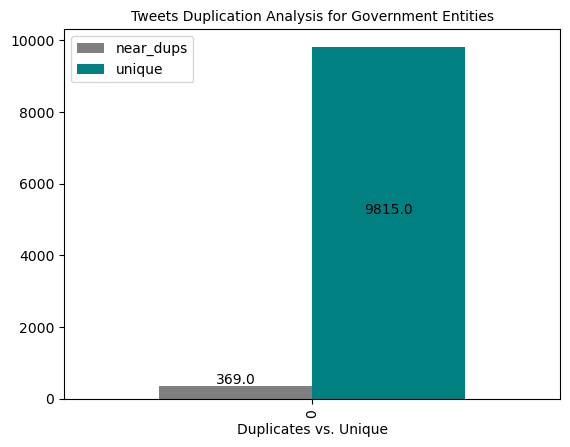

In [23]:
dups3_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups3_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['grey', 'teal'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets Duplication Analysis for Government Entities', fontsize=10)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2),  
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [24]:
sqlContext.clearCache()

#### Educational institution

In [25]:
#filter for Educational institution
edu_users = tweets_filt4.filter((tweets_filt4.user_category == 'School') | (tweets_filt4.user_category == 'University'))
edu_users.count()

2600559

In [29]:
edu_users_sample = edu_users.sample(False, 0.0038, 12345)
edu_users_sample.count()

10050

In [30]:
#select the text column from the data for further analysis
edu_users2 = edu_users_sample.select(["text"])
edu_users2.limit(5)

text
aeristres hi inte...
now hiring assist...
rt psclbaseball22...
rt devinmo4385895...
college career ge...


In [31]:
# drop any rows with null values
text = edu_users2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens1 = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [32]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{rt latrellray1 b...,47
{rt democracydock...,48
{rt beth_a_snowde...,49
{rt sarbanandsonw...,50
{at achieveatlant...,51


In [33]:
df_text_tokens = spark.createDataFrame(tokens1, ["words_list",'id'])

#Drop records with no tokens
df_text_tokens = df_text_tokens.where(col('words_list').getItem(0).isNotNull())
df_text_tokens.limit(5).toPandas()

,words_list,id
0,"[aeristres, hi, interested, po, dm, send, details, ng, ipapagawa, college, student, willing, help, po]",0
1,"[hiring, assistant, recruitment, database, manager, rollins, college, winter, park, fl, 32789, https, tco, adl3snugwg]",1
2,"[rt, psclbaseball22, welcome, pscl, mason, schwalbach, mchenry, county, college, players, apply, https, tco, igg8vdpcpi, http]",2
3,"[rt, devinmo43858959, blessed, receive, first, offer, notre, dame, college, coachwinterswhs, whitmerfb, https, tco, 4gl]",3
4,"[college, career, gear, day, cherryhillwest, chpstweets, kcream24, melochejoe, https, tco, syg5zzdngw]",4


In [34]:
#Fit countvectorizer to create word features
vectorize1 = CountVectorizer(inputCol="words_list", outputCol="features", minDF=1.0)
df_text_vectorize = vectorize1.fit(df_text_tokens).transform(df_text_tokens)

In [35]:
df_text_vectorize.limit(5).toPandas()

,words_list,id,features
0,"[aeristres, hi, interested, po, dm, send, details, ng, ipapagawa, college, student, willing, help, po]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[hiring, assistant, recruitment, database, manager, rollins, college, winter, park, fl, 32789, https, tco, adl3snugwg]",1,"(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, psclbaseball22, welcome, pscl, mason, schwalbach, mchenry, county, college, players, apply, https, tco, igg8vdpcpi, http]",2,"(1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, devinmo43858959, blessed, receive, first, offer, notre, dame, college, coachwinterswhs, whitmerfb, https, tco, 4gl]",3,"(1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[college, career, gear, day, cherryhillwest, chpstweets, kcream24, melochejoe, https, tco, syg5zzdngw]",4,"(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [36]:
#Fit MinHashLSH to create hash table
mh1 = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model1 = mh1.fit(df_text_vectorize)
df_hashed1 = model1.transform(df_text_vectorize).cache()

In [37]:
df_hashed_text = df_text.join(df_hashed1, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,words_list,features,hashes
19,{rt noahengelman ...,"[rt, noahengelman...","(31813,[2,5,21,23...","[[2.61390943E8], ..."
54,{rt spartanscreat...,"[rt, spartanscrea...","(31813,[2,7,11,20...","[[1.65518591E8], ..."
296,{jennifer horath ...,"[jennifer, horath...","(31813,[0,1,3,48,...","[[4.7945584E7], [..."
926,{ksirach the scho...,"[ksirach, school,...","(31813,[0,1,3,14,...","[[4.7945584E7], [..."
965,{college career f...,"[college, career,...","(31813,[0,1,3,5,7...","[[4.7945584E7], [..."


In [38]:
#Establish similarity threshold and return near-duplicate records
jaccard_distance = 0.3

df_dups_text3 = model1.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [39]:
df_dups_30 = df_dups_text3
df_dups_text3.cache()
df_dups_text3.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.133333,4098,7847,"(free education university how to find scholarships and grants specifically tailored to your personality type hob https tco 3arnpgsglk,)","(free education university how to find scholarships and grants specifically tailored to your personality type hob https tco 9erszfzyks,)"
1,0.176471,5441,8928,"(ml_philosophy aloha miss faye right here second year college student an english major i am open for academi https tco 9diwi20441,)","(joenasandiego aloha miss faye right here second year college student an english major i am open for academi https tco rccriwivj6,)"
2,0.285714,304,6283,"(time management secrets for college students the underground playbook for ma https tco bw9cpzj8vc via https tco azuemie9hj,)","(time management secrets for college students the underground playbook for ma https tco 9gqpvmcmzy via https tco fbmfl5qa9u,)"
3,0.000000,1961,6539,"(rt savebirkbeck no job cuts at birkbeck university of london savebirkbeck https tco awjczgmb7b,)","(rt savebirkbeck no job cuts at birkbeck university of london savebirkbeck https tco awjczgmb7b,)"
4,0.285714,1828,1829,"(high school soccer live stream washington vs jeannette watch live https tco n0n5g4y8ai,)","(high school soccer live stream pewaukee vs muskego watch live https tco n0n5g4y8ai,)"


In [40]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
proportion_dups = dups/records
uniques = records - dups
proportion_uniques = uniques/records

print('Total records: ', records)
print('Proportion of duplicates based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_dups)
print('Proportion of unique records based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_uniques)

Total records:  10050
Proportion of duplicates based on { 0.3 } jaccard distance proportion:  0.022686567164179106
Proportion of unique records based on { 0.3 } jaccard distance proportion:  0.977313432835821


In [41]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10050
Duplicate titles based on { 0.3 } jaccard distance:  228
Unique titles based on { 0.3 } jaccard distance:  0.3 :  9822


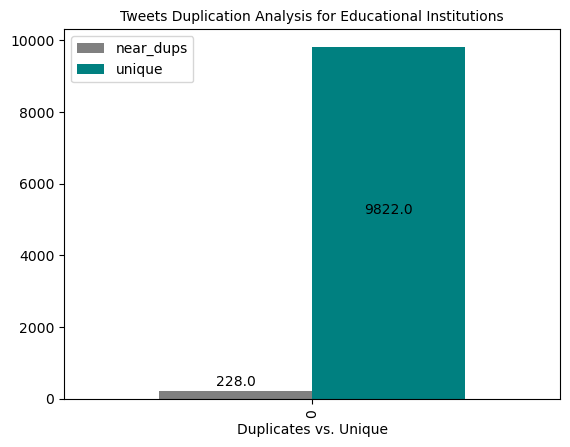

In [42]:
dups3_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups3_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['grey', 'teal'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets Duplication Analysis for Educational Institutions', fontsize=10)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2),  
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [43]:
sqlContext.clearCache()

#### News outlet

In [44]:
#filter for news outlet
news_users = tweets_filt4.filter(tweets_filt4.user_category == 'News Outlet')
news_users.count()

1626260

In [46]:
news_users_sample = news_users.sample(False, 0.0061, 12345)
news_users_sample.count()

10065

In [47]:
#select the text column from the data for further analysis
news_users2 = news_users_sample.select(["text"])
news_users2.limit(5)

text
rt followosha the...
katehasthoughts 2...
ad nike dunk high...
rt _oluwaseun9 ja...
rt alexokoroji ye...


In [48]:
# drop any rows with null values
text = news_users2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens1 = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [49]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{rt outofcontrolj...,437
{high school ice ...,438
{next years high ...,439
{rt ewangibbs i f...,440
{over 22million f...,441


In [50]:
df_text_tokens = spark.createDataFrame(tokens1, ["words_list",'id'])

#Drop records with no tokens
df_text_tokens = df_text_tokens.where(col('words_list').getItem(0).isNotNull())
df_text_tokens.limit(5).toPandas()

,words_list,id
0,"[rt, followosha, university, ilesa, osun, state, establishment, bill, 2022, passed, second, reading, today, plenary, state]",0
1,"[katehasthoughts, kids, college, contest, https, tco, lcucvl7zyu]",1
2,"[ad, nike, dunk, high, retro, university, gold, black, white, habanero, red, dd1399, 700, shiekh, app, https, tco, 35zmgsdckp]",2
3,"[rt, jamb, approves, 140, new, cut, mark, na, people, like, portable, go, full, university]",3
4,"[rt, alexokoroji, yesterday, special, day, conferred, doctor, philosophy, dphil, honoris, causa, rai, university, indi]",4


In [51]:
#Fit countvectorizer to create word features
vectorize1 = CountVectorizer(inputCol="words_list", outputCol="features", minDF=1.0)
df_text_vectorize = vectorize1.fit(df_text_tokens).transform(df_text_tokens)

In [52]:
df_text_vectorize.limit(5).toPandas()

,words_list,id,features
0,"[rt, followosha, university, ilesa, osun, state, establishment, bill, 2022, passed, second, reading, today, plenary, state]",0,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[katehasthoughts, kids, college, contest, https, tco, lcucvl7zyu]",1,"(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[ad, nike, dunk, high, retro, university, gold, black, white, habanero, red, dd1399, 700, shiekh, app, https, tco, 35zmgsdckp]",2,"(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, jamb, approves, 140, new, cut, mark, na, people, like, portable, go, full, university]",3,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, alexokoroji, yesterday, special, day, conferred, doctor, philosophy, dphil, honoris, causa, rai, university, indi]",4,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [53]:
#Fit MinHashLSH to create hash table
mh1 = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model1 = mh1.fit(df_text_vectorize)
df_hashed1 = model1.transform(df_text_vectorize).cache()

In [54]:
df_hashed_text = df_text.join(df_hashed1, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,words_list,features,hashes
222,{analysis the bio...,"[analysis, biodiv...","(30678,[0,1,4,448...","[[4.7945584E7], [..."
270,{9 year old boy f...,"[year, old, boy, ...","(30678,[0,1,3,6,1...","[[4.7945584E7], [..."
293,{rt moreperfectus...,"[rt, moreperfectu...","(30678,[2,4,10,14...","[[3.9873116E7], [..."
730,{rt capetownetc c...,"[rt, capetownetc,...","(30678,[2,5,409,5...","[[1.82676517E8], ..."
938,{she then enrolle...,"[enrolled, queens...","(30678,[0,1,3,5,1...","[[4.7945584E7], [..."


In [55]:
#Establish similarity threshold and return near-duplicate records
jaccard_distance = 0.3

df_dups_text3 = model1.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [56]:
df_dups_30 = df_dups_text3
df_dups_text3.cache()
df_dups_text3.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,3551,7341,"(rt qasimrashid keenan anderson a 31 year old high school teacher amp father stopped la police for help after an accident they instead cuff,)","(rt qasimrashid keenan anderson a 31 year old high school teacher amp father stopped la police for help after an accident they instead cuff,)"
1,0.0,3829,6603,"(rt clairecmc i can t in good conscience recommend young women go to colleges in states where taking a morning after pill could make them,)","(rt clairecmc i can t in good conscience recommend young women go to colleges in states where taking a morning after pill could make them,)"
2,0.2,2132,7960,"(rt sadlifeebro every college student knows the importance of 11 59,)","(rt noorthevirgo every college student knows the importance of 11 59,)"
3,0.0,9788,9870,"(rt maassp high school senior who just defeated a far right candidate in idaho we used to have climate strikes like back in ninth grad,)","(rt maassp high school senior who just defeated a far right candidate in idaho we used to have climate strikes like back in ninth grad,)"
4,0.0,2722,6728,"(rt itsmestacyz can we students rest like a real rest even just for a day without being anxio,)","(rt itsmestacyz can we students rest like a real rest even just for a day without being anxio,)"


In [57]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
proportion_dups = dups/records
uniques = records - dups
proportion_uniques = uniques/records

print('Total records: ', records)
print('Proportion of duplicates based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_dups)
print('Proportion of unique records based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_uniques)

Total records:  10065
Proportion of duplicates based on { 0.3 } jaccard distance proportion:  0.03596621957277695
Proportion of unique records based on { 0.3 } jaccard distance proportion:  0.9640337804272231


In [58]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10065
Duplicate titles based on { 0.3 } jaccard distance:  362
Unique titles based on { 0.3 } jaccard distance:  0.3 :  9703


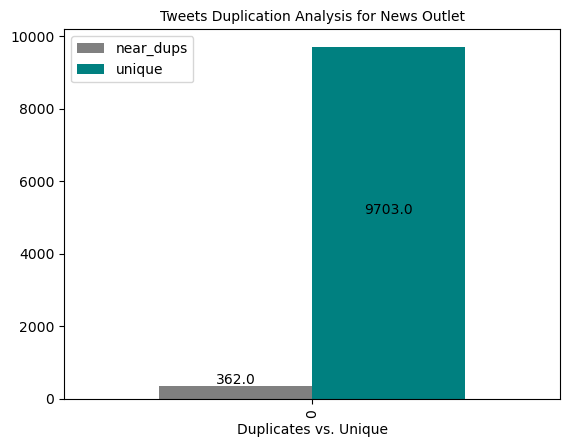

In [59]:
dups3_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups3_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['grey', 'teal'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets Duplication Analysis for News Outlet', fontsize=10)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2),  
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [60]:
sqlContext.clearCache()

#### Social media influencer

In [61]:
#filter for social media influencer
influencer_users = tweets_filt4.filter(tweets_filt4.user_category == 'Social Media Influencer')
influencer_users.count()

1080789

In [64]:
influencer_users_sample = influencer_users.sample(False, 0.0093, 12345)
influencer_users_sample.count()

10079

In [65]:
#select the text column from the data for further analysis
influencer_users2 = influencer_users_sample.select(["text"])
influencer_users2.limit(5)

text
journal impact fa...
rt tomfitton brea...
rt danielashley13...
rt lincolnmjay ha...
rt jaylanier12 da...


In [66]:
# drop any rows with null values
text = influencer_users2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens1 = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [67]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{stranger things ...,500
{rt landmarkcolle...,501
{cute transfer st...,502
{serapath i have ...,503
{iowa high school...,504


In [68]:
df_text_tokens = spark.createDataFrame(tokens1, ["words_list",'id'])

#Drop records with no tokens
df_text_tokens = df_text_tokens.where(col('words_list').getItem(0).isNotNull())
df_text_tokens.limit(5).toPandas()

,words_list,id
0,"[journal, impact, factor, university, texas, dallas, financial, times, listing, journal, article, level, https, tco, rqukefoirw]",0
1,"[rt, tomfitton, breaking, nytimes, upset, high, school, textbooks, anti, american, enough, https, tco, rjwd3otnbp]",1
2,"[rt, danielashley13, ideastosupplementyourincome, retired, teacher, get, cdl, drive, school, bus, https, tco, lofzsrr5zt]",2
3,"[rt, lincolnmjay, happening, students, joined, protestors, outside, oakville, trafalgar, high, school, speak, teacher, wh]",3
4,"[rt, jaylanier12, damehova9, jayceon, lanier, pos, rb, de, class, 23, ht, wt, 235, school, metter, high, school, gpa, 30, city, state, georgia]",4


In [69]:
#Fit countvectorizer to create word features
vectorize1 = CountVectorizer(inputCol="words_list", outputCol="features", minDF=1.0)
df_text_vectorize = vectorize1.fit(df_text_tokens).transform(df_text_tokens)

In [70]:
df_text_vectorize.limit(5).toPandas()

,words_list,id,features
0,"[journal, impact, factor, university, texas, dallas, financial, times, listing, journal, article, level, https, tco, rqukefoirw]",0,"(0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[rt, tomfitton, breaking, nytimes, upset, high, school, textbooks, anti, american, enough, https, tco, rjwd3otnbp]",1,"(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, danielashley13, ideastosupplementyourincome, retired, teacher, get, cdl, drive, school, bus, https, tco, lofzsrr5zt]",2,"(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, lincolnmjay, happening, students, joined, protestors, outside, oakville, trafalgar, high, school, speak, teacher, wh]",3,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, jaylanier12, damehova9, jayceon, lanier, pos, rb, de, class, 23, ht, wt, 235, school, metter, high, school, gpa, 30, city, state, georgia]",4,"(1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [71]:
#Fit MinHashLSH to create hash table
mh1 = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model1 = mh1.fit(df_text_vectorize)
df_hashed1 = model1.transform(df_text_vectorize).cache()

In [72]:
df_hashed_text = df_text.join(df_hashed1, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,words_list,features,hashes
0,{journal impact f...,"[journal, impact,...","(29091,[1,2,5,80,...","[[1.71580805E8], ..."
277,{octonion 1st yea...,"[octonion, 1st, y...","(29091,[4,17,379,...","[[1.010261747E9],..."
287,{wait i love the ...,"[wait, love, ball...","(29091,[1,2,3,9,2...","[[1.54921511E8], ..."
348,{rt naacpimageawa...,"[rt, naacpimageaw...","(29091,[0,5,17,11...","[[4567863.0], [3...."
415,{i cba to fight w...,"[cba, fight, disa...","(29091,[1,2,5,269...","[[2.09418533E8], ..."


In [73]:
#Establish similarity threshold and return near-duplicate records
jaccard_distance = 0.3

df_dups_text3 = model1.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [74]:
df_dups_30 = df_dups_text3
df_dups_text3.cache()
df_dups_text3.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.166667,803,2099,"(his focus was on building a school while hers was on education what they didn t realize though was that life would https tco miipzuvwvb,)","(his focus was on building a school while hers was on education what they didn t realize though was that life would https tco xwgzveu9s8,)"
1,0.000000,238,2169,"(rt stevehofstetter the generation that could buy a house with a part time job and went to college for 5k sure likes to tell everyone how,)","(rt stevehofstetter the generation that could buy a house with a part time job and went to college for 5k sure likes to tell everyone how,)"
2,0.095238,2256,6450,"(rt lookk234 review 004 ssni 802 poor teacher trapped at school during a storm english explanation issue 4th part10 full amp hd versio,)","(rt lookk234 review 004 ssni 802 poor teacher trapped at school during a storm english explanation issue 4th part12 full amp hd versio,)"
3,0.000000,8193,9308,"(rt mariagenerous titled plots at busika town council behind bugema university main campus 50 100 18m 15 km from the tarmac electr,)","(rt mariagenerous titled plots at busika town council behind bugema university main campus 50 100 18m 15 km from the tarmac electr,)"
4,0.166667,3086,4456,"(his focus was on building a school while hers was on education what they didn t realize though was that life would https tco wx9sdxoyox,)","(his focus was on building a school while hers was on education what they didn t realize though was that life would https tco dwpsaowlzm,)"


In [75]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
proportion_dups = dups/records
uniques = records - dups
proportion_uniques = uniques/records

print('Total records: ', records)
print('Proportion of duplicates based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_dups)
print('Proportion of unique records based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_uniques)

Total records:  10079
Proportion of duplicates based on { 0.3 } jaccard distance proportion:  0.0744121440619109
Proportion of unique records based on { 0.3 } jaccard distance proportion:  0.9255878559380891


In [76]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10079
Duplicate titles based on { 0.3 } jaccard distance:  750
Unique titles based on { 0.3 } jaccard distance:  0.3 :  9329


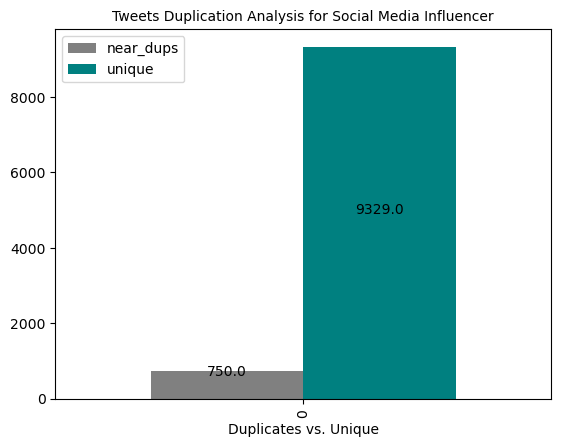

In [77]:
dups3_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups3_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['grey', 'teal'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets Duplication Analysis for Social Media Influencer', fontsize=10)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2),  
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [78]:
sqlContext.clearCache()

#### Non-profit organization

In [79]:
#filter for non-profit organization
ngo_users = tweets_filt4.filter(tweets_filt4.user_category == 'Nonprofit Organization')
ngo_users.count()

207936

In [80]:
ngo_users_sample = ngo_users.sample(False, 0.048, 12345)
ngo_users_sample.count()

10044

In [81]:
#select the text column from the data for further analysis
ngo_users2 = ngo_users_sample.select(["text"])
ngo_users2.limit(5)

text
rt hannahkrieg th...
elementary school...
homelessness surg...
rt ucustandard ug...
rt cav_peteam the...


In [82]:
# drop any rows with null values
text = ngo_users2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens1 = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [83]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{how does deafnes...,35
{this past weeken...,36
{the moes in ugan...,37
{rt wjbf eligibil...,38
{rt acarpendigita...,39


In [84]:
df_text_tokens = spark.createDataFrame(tokens1, ["words_list",'id'])

#Drop records with no tokens
df_text_tokens = df_text_tokens.where(col('words_list').getItem(0).isNotNull())
df_text_tokens.limit(5).toPandas()

,words_list,id
0,"[rt, hannahkrieg, morning, ingraham, high, school, students, seattle, students, union, organized, district, wide, walk, st]",0
1,"[elementary, school, https, tco, umddisueve]",1
2,"[homelessness, surges, among, memphis, shelby, county, schools, students, https, tco, owpy85qq2z]",2
3,"[rt, ucustandard, uganda, christian, university, ucu, retained, national, council, higher, education, exhibition, award, fourth]",3
4,"[rt, macmillan, information, support, centre, university, hospital, wales, closed, notice, please, contact]",4


In [85]:
#Fit countvectorizer to create word features
vectorize1 = CountVectorizer(inputCol="words_list", outputCol="features", minDF=1.0)
df_text_vectorize = vectorize1.fit(df_text_tokens).transform(df_text_tokens)

In [86]:
#Fit MinHashLSH to create hash table
mh1 = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model1 = mh1.fit(df_text_vectorize)
df_hashed1 = model1.transform(df_text_vectorize).cache()

In [87]:
df_hashed_text = df_text.join(df_hashed1, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,words_list,features,hashes
237,{rt meakoopa in s...,"[rt, meakoopa, st...","(29882,[0,3,12,19...","[[4.7945584E7], [..."
241,{rt bbcwomanshour...,"[rt, bbcwomanshou...","(29882,[0,3,74,17...","[[4.7945584E7], [..."
347,{d_co0p jasoncver...,"[jasoncvercko, mi...","(29882,[1,2,3,6,1...","[[5.7031042E7], [..."
564,{rt thebhanuu las...,"[rt, thebhanuu, l...","(29882,[0,1,2,5,8...","[[4.7945584E7], [..."
588,{doyon foundation...,"[doyon, foundatio...","(29882,[1,2,3,7,1...","[[1.73116016E8], ..."


In [88]:
#Establish similarity threshold and return near-duplicate records
jaccard_distance = 0.3

df_dups_text3 = model1.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [89]:
df_dups_30 = df_dups_text3
df_dups_text3.cache()
df_dups_text3.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.250000,1989,2604,"(orltzy henlo we re interested commsnifleurir_ consists of a college commer taking educ major in english amp her https tco ba3ibclakg,)","(powza10 henlo we re interested commsnifleurir_ consists of a college commer taking educ major in english amp he https tco 7bdplvpgpl,)"
1,0.217391,5848,7850,"(umbradylan andre washington c o 23 de dt 6 2 210 lbs 28 gpa durango high school las vegas nv full vid on my https tco gnt110m4kz,)","(ab_thelegend andre washington c o 23 de dt 6 2 220 lbs 28 gpa durango high school las vegas nv full vid on https tco 1jndw6h3yg,)"
2,0.000000,3968,7947,"(rt itsmutai this is a kenyan girl called diana chepkemoi meru university student who went to find work in saudi arabia she went healthy,)","(rt itsmutai this is a kenyan girl called diana chepkemoi meru university student who went to find work in saudi arabia she went healthy,)"
3,0.000000,1929,4130,"(rt guccithirdleg teanna trump suckin my dick in college who next https tco py8yrxk8po,)","(rt guccithirdleg teanna trump suckin my dick in college who next https tco py8yrxk8po,)"
4,0.000000,1470,9981,"(rt tyler02020202 i can t put into words how humbling being in college was during fall 2020 like everyday was a battle,)","(rt tyler02020202 i can t put into words how humbling being in college was during fall 2020 like everyday was a battle,)"


In [90]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
proportion_dups = dups/records
uniques = records - dups
proportion_uniques = uniques/records

print('Total records: ', records)
print('Proportion of duplicates based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_dups)
print('Proportion of unique records based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_uniques)

Total records:  10044
Proportion of duplicates based on { 0.3 } jaccard distance proportion:  0.05744723217841497
Proportion of unique records based on { 0.3 } jaccard distance proportion:  0.942552767821585


In [91]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10044
Duplicate titles based on { 0.3 } jaccard distance:  577
Unique titles based on { 0.3 } jaccard distance:  0.3 :  9467


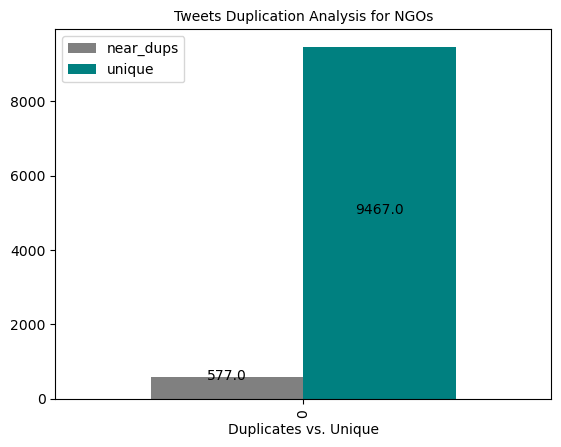

In [92]:
dups3_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups3_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['grey', 'teal'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets Duplication Analysis for NGOs', fontsize=10)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2),  
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [93]:
sqlContext.clearCache()

#### Other

In [94]:
#filter for other
other_users = tweets_filt4.filter(tweets_filt4.user_category == 'Someone Else')
other_users.count()

29954803

In [98]:
other_users_sample = other_users.sample(False, 0.000333, 12345)
other_users_sample.count()

10040

In [99]:
#select the text column from the data for further analysis
other_users2 = other_users_sample.select(["text"])
other_users2.limit(5)

text
rt okay_nadiaa as...
gt livestream hd ...
matthew82069336 f...
rt koresystem a s...
notre dame was am...


In [100]:
# drop any rows with null values
text = other_users2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens1 = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [101]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{rt theerealdeeee...,368
{rt irgarner teac...,369
{rt bryanpassink ...,370
{rt twee_teez jea...,371
{rt daveatherton2...,372


In [102]:
df_text_tokens = spark.createDataFrame(tokens1, ["words_list",'id'])

#Drop records with no tokens
df_text_tokens = df_text_tokens.where(col('words_list').getItem(0).isNotNull())
df_text_tokens.limit(5).toPandas()

,words_list,id
0,"[rt, college, student, tired]",0
1,"[gt, livestream, hd, high, school, girls, basketball, 2022, lt, shawe, memorial, vs, hauser, watch, live, hd, https, tco, amin8uuyav]",1
2,"[matthew82069336, first, day, eton, college, lesson, lie, much, possible, whenever, possible, bullshit, https, tco, q5jmal5vsu]",2
3,"[rt, koresystem, study, carried, climate, scientists, university, college, cork, affirms, solar, panels, could, power, quarter, ir]",3
4,"[notre, dame, among, elite, elite, women, college, basketball, https, tco, rsrjto0g7a]",4


In [103]:
#Fit countvectorizer to create word features
vectorize1 = CountVectorizer(inputCol="words_list", outputCol="features", minDF=1.0)
df_text_vectorize = vectorize1.fit(df_text_tokens).transform(df_text_tokens)

In [104]:
#Fit MinHashLSH to create hash table
mh1 = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model1 = mh1.fit(df_text_vectorize)
df_hashed1 = model1.transform(df_text_vectorize).cache()

In [105]:
df_hashed_text = df_text.join(df_hashed1, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,words_list,features,hashes
243,{truth if that co...,"[truth, college, ...","(28400,[4,57,68,7...","[[8.31591557E8], ..."
278,{rt frontendla ca...,"[rt, frontendla, ...","(28400,[0,2,10,56...","[[4.7945584E7], [..."
367,{rt proffeynman s...,"[rt, proffeynman,...","(28400,[0,1,7,10,...","[[4.7945584E7], [..."
442,{lausdsup laschoo...,"[lausdsup, lascho...","(28400,[1,2,3,6,5...","[[1.07998325E8], ..."
705,{rt chude__ elder...,"[rt, elder, state...","(28400,[0,5,122,2...","[[4.7945584E7], [..."


In [106]:
#Establish similarity threshold and return near-duplicate records
jaccard_distance = 0.3

df_dups_text3 = model1.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [107]:
df_dups_30 = df_dups_text3
df_dups_text3.cache()
df_dups_text3.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,2210,7022,"(rt ishacouturee being close friends with someone since elementary middle school is such a surreal experience because you literally watch,)","(rt ishacouturee being close friends with someone since elementary middle school is such a surreal experience because you literally watch,)"
1,0.0,994,8035,"(greatness i evaluating the benefits and drawbacks of any university worth the name archangel zadkiel,)","(greatness i evaluating the benefits and drawbacks of any university worth the name archangel zadkiel,)"
2,0.0,631,1437,"(rt therealcliffyb as someone who played mercutio in high school pretty much this dramanerd https tco poyyfvxlza,)","(rt therealcliffyb as someone who played mercutio in high school pretty much this dramanerd https tco poyyfvxlza,)"
3,0.0,8968,9309,"(rt abir1971_das jyoti ghosh 20 a student of nazrul college in dhaka was abducted by some local muslims vijay ahmed forcibly convert,)","(rt abir1971_das jyoti ghosh 20 a student of nazrul college in dhaka was abducted by some local muslims vijay ahmed forcibly convert,)"
4,0.0,5785,5959,"(rt davidhundeyin forged chicago state university certificate check false works history claims check failure to disclose apparent du,)","(rt davidhundeyin forged chicago state university certificate check false works history claims check failure to disclose apparent du,)"


In [108]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
proportion_dups = dups/records
uniques = records - dups
proportion_uniques = uniques/records

print('Total records: ', records)
print('Proportion of duplicates based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_dups)
print('Proportion of unique records based on {', jaccard_distance, '} jaccard distance proportion: ', proportion_uniques)

Total records:  10040
Proportion of duplicates based on { 0.3 } jaccard distance proportion:  0.0944223107569721
Proportion of unique records based on { 0.3 } jaccard distance proportion:  0.9055776892430278


In [109]:
records = df_hashed_text.count()
dups = df_dups_text3.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10040
Duplicate titles based on { 0.3 } jaccard distance:  948
Unique titles based on { 0.3 } jaccard distance:  0.3 :  9092


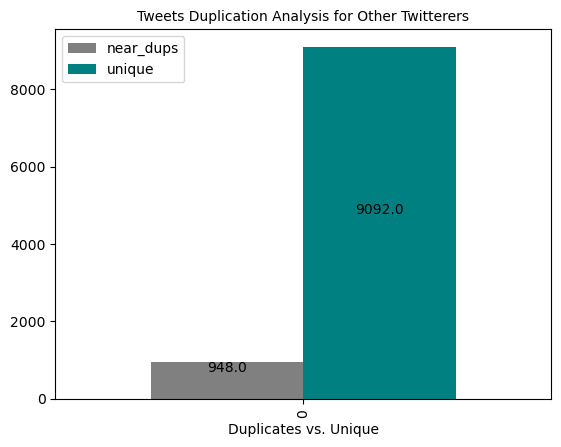

In [110]:
dups3_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups3_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['grey', 'teal'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets Duplication Analysis for Other Twitterers', fontsize=10)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2),  
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [111]:
sqlContext.clearCache()

In [44]:
original_tweet_sample.select('user_category').distinct().rdd.map(lambda x: x[0]).collect()

['Someone Else',
 'School',
 'Social Media Influencer',
 'Government Entity',
 'Nonprofit Organization',
 'News Outlet',
 'University']